# SnakeRL

The aim of this work is to develop an AI that can play Snake.

2021-11-15 17:43:07.790311: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-15 17:43:07.790327: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2.6.0


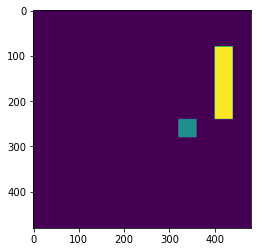

In [1]:
%matplotlib inline
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from game import Snake
import numpy as np
import cv2
import random
from numpy import zeros, newaxis
from tqdm import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import rcParams

print(tf.__version__)

field_w = 12
field_h = 12
scale_percent = 40

game = Snake(field_w, field_h)

plt.imshow(game.generate_image(scale_percent=scale_percent))
plt.show()
plt.style.use('seaborn')

# Hyperparameters

In [2]:
epsilon = 0.99
learning_rate = 0.01
#learning_rate = 0.00025
epsilon_min = 0.01
width = game.generate_image().shape[0]
height = game.generate_image().shape[1]
batch_size = 32
gamma = 0.99
update_every_frame =  4
num_actions = 4
update_target_network = 10000
num_episodes = 100000
frame_count = 0

# Replay Memory

In [3]:
from collections import deque

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, value):
        """Save a transition"""
        self.memory.append(value)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Network

I used Huber as loss function and Adam as optimizer.

In [4]:
input_1 = [game.generate_image().reshape(width, height)]
input_2 = [game.generate_image().reshape(width, height)]
input_3 = [game.generate_image().reshape(width, height)]
input_4 = [game.generate_image().reshape(width, height)]
input_shape = np.vstack((input_1, input_2)).shape

loss_function = tf.keras.losses.Huber()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)

print(input_shape)

def create_model():
  model = models.Sequential()
  model.add(layers.Conv2D(48, (3, 3), activation='relu',padding='same', input_shape=input_shape))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu',padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2),padding='same'))
  model.add(layers.Conv2D(192, (2, 2), activation='relu',padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2),padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Flatten())
  model.add(layers.Dropout(0.4))
  model.add(layers.Dense(258, activation='relu'))
  model.add(layers.Dropout(0.4))
  model.add(layers.Dense(258, activation='relu'))
  model.add(layers.Dropout(0.4))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(4, activation='linear'))
  #model.compile(loss=loss_function, optimizer=optimizer)
  return model

(2, 12, 12)


In [5]:
memory = ReplayMemory(100000)
av_fun = create_model()
target_av_fun = create_model()
target_av_fun.set_weights(av_fun.get_weights())
av_fun.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 2, 12, 48)         5232      
_________________________________________________________________
batch_normalization (BatchNo (None, 2, 12, 48)         192       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 6, 48)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 6, 128)         55424     
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 6, 128)         512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 3, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 3, 192)         9

2021-11-15 17:43:08.772359: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2021-11-15 17:43:08.772384: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: terrasauro2
2021-11-15 17:43:08.772389: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: terrasauro2
2021-11-15 17:43:08.772439: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 460.91.3
2021-11-15 17:43:08.772456: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 450.119.3
2021-11-15 17:43:08.772461: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 450.119.3 does not match DSO version 460.91.3 -- cannot find working devices in this configuration
2021-11-15 17:43:08.772833: I tensorflow/core/platform/cpu_feature_guard.cc:142] This Te

# Training

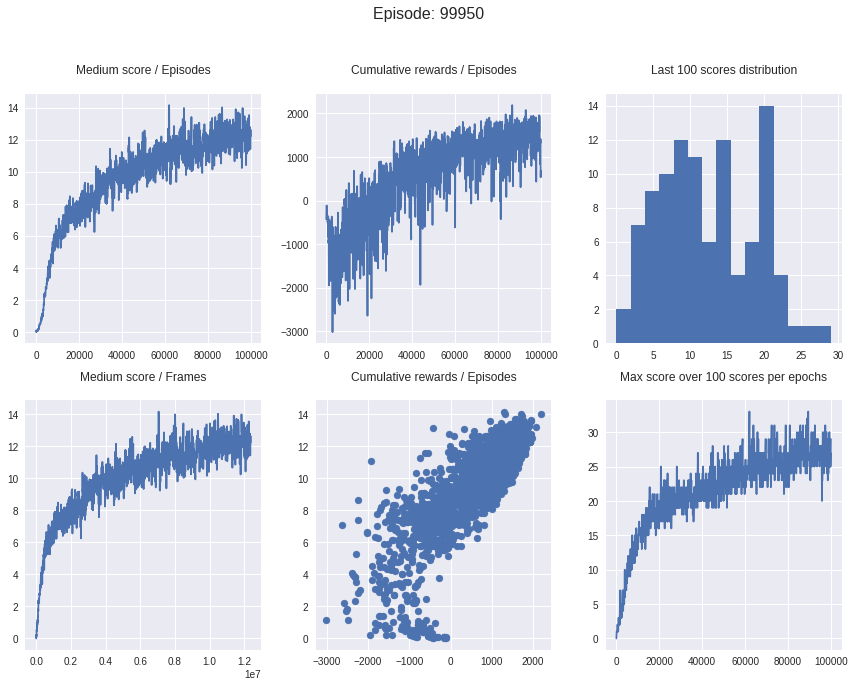

100%|███████████████████████████████| 100000/100000 [130:43:46<00:00,  4.71s/it]


In [6]:
rewards_ep = 0
score_ep = []
general_score = []
max_score_local_tot = []
running_reward = 0
running_score = 0
episode_count = 0
episode_reward_history = []
reward_history_tot = []
max_score_tot = []
score_history_tot = []
ep_history_tot = []
frame_history_tot = []
general_max_history_tot = []

for i in tqdm(range(0, num_episodes)):
  env = Snake(field_w, field_h)
  st_1 = [env.generate_image().reshape(width, height)]
  st_2 = [env.generate_image().reshape(width, height)]
  st_3 = [env.generate_image().reshape(width, height)]
  st_4 = [env.generate_image().reshape(width, height)]
  input_shape = np.vstack((st_1, st_2, st_3, st_4))
  rewards = 0
  episode_reward = 0
  # Play the game
  while not env.end:
    frame_count += 1
    st_1 = st_2
    st_2 = st_3 
    st_3 = st_4
    st_4 = [env.generate_image().reshape(width, height)]
    st = np.vstack((st_1, st_2, st_3, st_4))
    if np.random.rand() < epsilon:
      action = random.randrange(4)
    else:
      action = np.argmax(av_fun.predict(np.array( [st,] ))[0]) 
    epsilon = max(epsilon * 0.9, epsilon_min)
    next_state, reward, done = env.next_move(action + 37)
    rewards += reward
    episode_reward += reward
    next_state_op = np.vstack((st_2, st_3, st_4, [next_state.reshape(width, height)]))
    memory.push((st, action, reward, next_state_op, done))
    
    if frame_count % update_every_frame == 0 and len(memory) > batch_size:
      minibatch = memory.sample(batch_size)
      state_sample = np.array([value[0] for value in minibatch])
      action_sample = [value[1] for value in minibatch]
      rewards_sample = [value[2] for value in minibatch]
      next_state_sample = np.array([value[3] for value in minibatch])
      done_sample = np.array([float(value[4]) for value in minibatch])
      future_rewards = target_av_fun.predict(next_state_sample)
      updated_q_values = rewards_sample + gamma * tf.reduce_max(future_rewards, axis=1)
      updated_q_values = updated_q_values * (1 - done_sample) - done_sample
      masks = tf.one_hot(action_sample, num_actions)

      with tf.GradientTape() as tape:
          # Train the model on the states and updated Q-values
          q_values = av_fun(state_sample)

          # Apply the masks to the Q-values to get the Q-value for action taken
          q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
          # Calculate loss between new Q-value and old Q-value
          loss = loss_function(updated_q_values, q_action)

          # Backpropagation
          grads = tape.gradient(loss, av_fun.trainable_variables)
          optimizer.apply_gradients(zip(grads, av_fun.trainable_variables))
          if frame_count % update_target_network == 0:
            # update the the target network with new weights
            target_av_fun.set_weights(av_fun.get_weights())
      
  # Update running reward to check condition for solving
  episode_reward_history.append(episode_reward)
  if len(episode_reward_history) > 100:
      del episode_reward_history[:1]
  running_reward = np.mean(episode_reward_history)

  episode_count += 1
  # Update running score to check condition for solving
  general_score.append(env.score)
  score_ep.append(env.score)
  if len(score_ep) > 100:
    del score_ep[:1]
  running_score = np.mean(score_ep)

  # Plotting
  if i % 50 == 0:
    clear_output()
    rcParams['axes.titlepad'] = 20 
    fig, axs = plt.subplots(2, 3,figsize=(12,10))
    fig.suptitle('Episode: {}'.format(episode_count - 1), fontsize=16)
    ep_history_tot.append(episode_count)
    max_score_local_tot.append(np.amax(np.array(score_ep)))
    score_history_tot.append(running_score)
    reward_history_tot.append(running_reward)
    frame_history_tot.append(frame_count)
    general_max_history_tot.append(np.amax(np.array(general_score)))

    axs[0, 0].title.set_text('Medium score / Episodes')
    axs[0, 1].title.set_text('Cumulative rewards / Episodes')
    axs[0,2].title.set_text('Last 100 scores distribution')
    axs[1, 0].title.set_text('Medium score / Frames')
    axs[1, 1].title.set_text('Cumulative rewards / Episodes')
    axs[1,2].title.set_text('Max score over 100 scores per epochs')

    axs[0, 0].plot(ep_history_tot, score_history_tot)
    axs[0, 1].plot(ep_history_tot, reward_history_tot)
    axs[0,2].hist(score_ep, bins=15)
    axs[1, 0].plot(frame_history_tot, score_history_tot)
    axs[1, 1].scatter(reward_history_tot, score_history_tot)
    axs[1,2].plot(ep_history_tot, max_score_local_tot)

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('output.png')
    plt.show()

# Logging

In [7]:
import pandas as pd
stats = pd.DataFrame(np.column_stack([ep_history_tot, score_history_tot, reward_history_tot, general_max_history_tot, frame_history_tot]), 
                               columns=['Episode', 'Score', 'Rewards', 'Max Score', 'FrameCount'])
stats.to_csv("output.csv", index=False)
stats

,Episode,Score,Rewards,Max Score,FrameCount
0,1.0,0.000000,-430.000000,0.0,15.0
1,51.0,0.098039,-170.784314,1.0,408.0
2,101.0,0.050000,-143.200000,1.0,701.0
3,151.0,0.040000,-114.100000,1.0,1063.0
4,201.0,0.070000,-111.400000,1.0,1394.0
...,...,...,...,...,...
1995,99751.0,11.640000,1313.400000,33.0,12344567.0
1996,99801.0,11.410000,1416.100000,33.0,12350825.0
1997,99851.0,12.020000,1344.100000,33.0,12358627.0
1998,99901.0,12.630000,533.800000,33.0,12366451.0


# Model

In [11]:
target_av_fun.save('target_snake_model.h5')
av_fun.save('av_snake_model.h5')

# Testing

In [15]:
list_score = []

for i in range(0, 200):
    field = Snake(12, 12)
    st_1 = [field.generate_image().reshape(width, height)]
    st_2 = [field.generate_image().reshape(width, height)]
    st_3 = [field.generate_image().reshape(width, height)]
    st_4 = [field.generate_image().reshape(width, height)]
    while not field.end:
        st_1 = st_2
        st_2 = st_3 
        st_3 = st_4
        st_4 = [field.generate_image().reshape(width, height)]
        st = np.vstack((st_1, st_2, st_3, st_4))
        res = np.argmax(av_fun.predict(np.array( [st,] ))[0]) 
        field.next_move(37 + res)
    list_score.append(field.score)

print("Average score: {:.2f} \n Variance: {:.2f} \n Max Value: {}".format(np.mean(list_score), np.var(list_score), np.max(list_score)))

Average score: 12.15 
 Variance: 50.27 
 Max Value: 27
